Machine learning (metodo supervisado)

## ¿Qué determina realmente el precio de un auto?


# Que aprendera de esto
Al final de este caso, estará familiarizado con el uso de XGBoost como modelo de referencia para analizar qué variables influyen más en el precio de los autos usados. Específicamente, aprenderá cómo este algoritmo permite capturar relaciones no lineales y cuantificar la importancia relativa de cada feature, de tal manera que pueda intuir mejor qué factores realmente determinan el valor de un vehículo. Durante el estudio de caso, realizará un EDA detallado para comprender la estructura del conjunto de datos y detectar patrones relevantes.

## Introduccion al proyecto
*Contexto comercial.*

Trabaja para una empresa dedicada a la compra y venta de autos usados, donde miles de vehículos se publican diariamente con precios muy variables según sus características. Para mejorar la transparencia del mercado y optimizar las recomendaciones de precios, la empresa necesita comprender qué factores realmente determinan el valor final de un auto. Aunque los vendedores suelen basarse en intuiciones o comparaciones superficiales, la compañía busca un enfoque basado en datos que permita identificar con precisión qué atributos influyen más en el precio y en qué magnitud.

*Problema comercial.*

¿Cuáles son las variables que más impactan en el precio de un auto usado y cómo se puede cuantificar su importancia relativa?

*Contexto analítico.*

El equipo de datos le ha proporcionado un conjunto de información detallada sobre miles de vehículos, incluyendo características como los caballos, el torque, peso del vehiculo, millaje y otras especificaciones técnicas. A diferencia de otros casos, aquí no buscamos clasificar ni detectar anomalías, sino entender la estructura del mercado y determinar qué atributos explican mejor la variación en los precios. Para ello, utilizaremos XGBoost como modelo principal, aprovechando su capacidad para capturar relaciones complejas y generar métricas de importancia de variables.


## EDA

In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb



vemos las primeras filas del df para saber donde estamos parados

In [327]:
df=pd.read_csv('../data/datasetautostop.csv')
display(df.head())

,Brand,Model,Year,Country,Condition,Engine_Size,Horsepower,Torque,Weight,Top_Speed,...,Mileage,Popularity,Safety_Rating,Number_of_Owners,Market_Demand,Insurance_Cost,Production_Units,Log_Price,Log_Mileage,Modification
0,Nissan,720S,2006,Asia,used,3.7,420,705,1785,238,...,96664,Low,2,4,Medium,13410,5000,11.309352,11.479007,V-Spec
1,McLaren,911 Turbo S,2009,Europe,new,5.3,1104,766,992,386,...,159630,High,2,2,Medium,10795,1000,12.639334,11.980620,NaN
2,Chevrolet,M4 Competition,2009,USA,new,5.5,153,1573,2022,397,...,111496,High,1,2,Low,1716,20000,12.948902,11.621753,NaN
3,Bugatti,Chiron,1982,Asia,used,5.4,544,1009,1091,151,...,217228,High,2,4,Medium,11618,20000,11.725542,12.288707,NaN
4,Nissan,Chiron,2022,Europe,new,2.4,980,693,1232,385,...,150318,Low,3,2,Medium,11324,100000,11.229289,11.920515,NaN


Convertimos la columna year en formato fecha con datetime

In [328]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

Realizamos un informe de calidad de datos para saber todo las condiciones que tiene nuestro df

In [329]:

def informe_calidad_datos(df):
    print('--- INFORME DE CALIDAD DE DATOS ---')
    print('\nDimensiones del DataFrame:')
    print(f'Filas: {df.shape[0]}, Columnas: {df.shape[1]}')
    print('\nTipos de variables:')
    print(df.dtypes)
    print('\nValores nulos por columna:')
    print(df.isnull().sum())
    print('\nPorcentaje de valores nulos por columna:')
    print((df.isnull().mean()*100).round(2))
    print('\nCantidad de filas duplicadas:')
    print(df.duplicated().sum())
    print('\nEstadísticas descriptivas (numéricas):')
    print(df.describe().T)
    print('\nEstadísticas descriptivas (categóricas):')
    print(df.describe(include=['object', 'category']).T)
    print('\nValores únicos por columna:')
    print(df.nunique())
    print('\n--- FIN DEL INFORME ---')


informe_calidad_datos(df)

--- INFORME DE CALIDAD DE DATOS ---

Dimensiones del DataFrame:
Filas: 5000, Columnas: 27

Tipos de variables:
Brand                         object
Model                         object
Year                  datetime64[ns]
Country                       object
Condition                     object
Engine_Size                  float64
Horsepower                     int64
Torque                         int64
Weight                         int64
Top_Speed                      int64
Acceleration_0_100           float64
Fuel_Type                     object
Drivetrain                    object
Transmission                  object
Fuel_Efficiency              float64
CO2_Emissions                  int64
Price                          int64
Mileage                        int64
Popularity                    object
Safety_Rating                  int64
Number_of_Owners               int64
Market_Demand                 object
Insurance_Cost                 int64
Production_Units               int64
L

In [330]:
df = df.drop(columns='Modification', errors='ignore')

Se elimino la columna modification, debido a que era una columna que presentaba muchos valores nulos y no era de mucha importancia a la hora de usar el algoritmo

A continuacion nos preparamos para el analisis, como es imposible analizar año por año lo que hacemos es agrupar los años por decadas

In [331]:
def agrupar_por_decada(df):
    if not np.issubdtype(df['Year'].dtype, np.datetime64):
        df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    years = df['Year'].dt.year
    df['decada'] = (years // 10) * 10
    df['decada'] = df['decada'].astype(str) + "s"
    return df


df = agrupar_por_decada(df)
display(df[['Year', 'decada']].head())

,Year,decada
0,2006-01-01,2000s
1,2009-01-01,2000s
2,2009-01-01,2000s
3,1982-01-01,1980s
4,2022-01-01,2020s


## GRAFICO I
Este grafico esta diseñado con la finalidad de saber en que epoca se fabricaron mas autos.

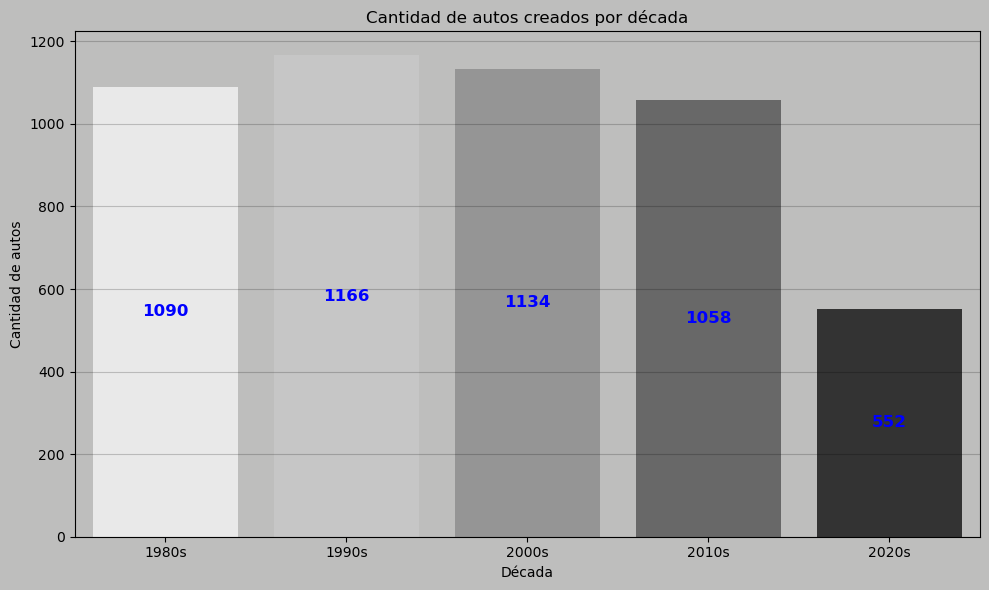

In [332]:
conteo_decadas = df['decada'].value_counts().sort_index()
fig, ax=plt.subplots(figsize=(10,6), facecolor='#BEBEBD')
ax.set_facecolor('#BEBEBD')
bars = sns.barplot(x=conteo_decadas.index, y=conteo_decadas.values,hue=conteo_decadas.index, palette="Greys", legend=False)
plt.xlabel('Década')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos creados por década')
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()

for bar, valor in zip(bars.patches, conteo_decadas.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        str(valor),
        ha='center',
        va='center',
        color='blue',
        fontweight='bold',
        fontsize=12
    )

plt.show()

### Conclusión del gráfico de autos por década
Como conclusión del primer gráfico podemos ver claramente cómo los años 1990s y 2000s fueron la década donde más autos se fabricaron con respecto a las otras.

## GRAFICO II
Este grafico esta diseñado con la finalidad de saber que tipo de traccion es la mas utilizada en el mundo automovil.

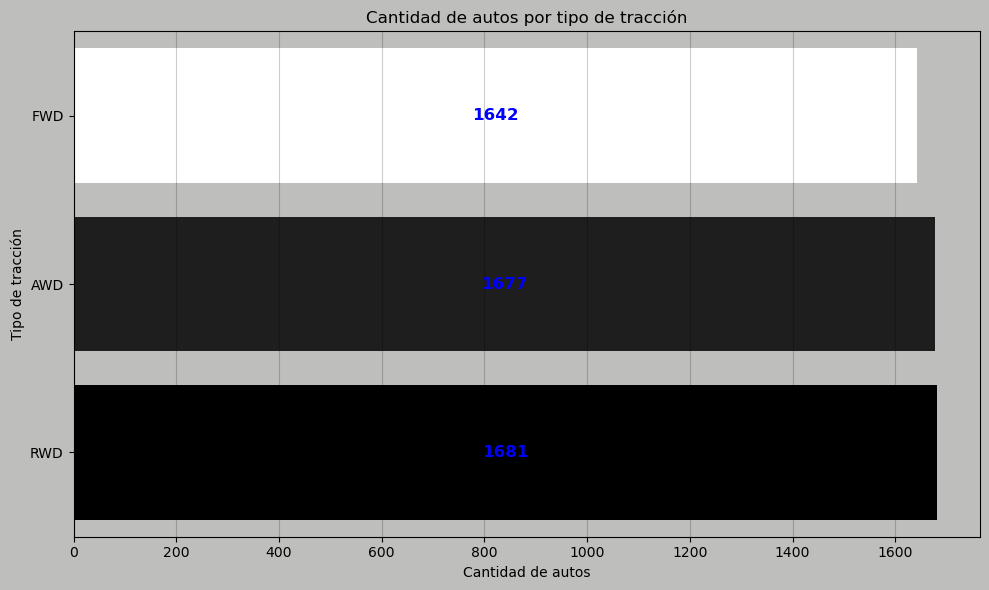

In [333]:
conteo_traccion = df['Drivetrain'].value_counts().sort_values()

# Crear figura con fondo blanco hueso oscuro
fig, ax = plt.subplots(figsize=(10,6), facecolor='#BEBEBD')
ax.set_facecolor("#BEBEBD")

bars = sns.barplot(x=conteo_traccion.values, y=conteo_traccion.index, hue=conteo_traccion.values, palette="Greys", legend=False, ax=ax)
plt.xlabel('Cantidad de autos')
plt.ylabel('Tipo de tracción')
plt.title('Cantidad de autos por tipo de tracción')
plt.grid(axis='x', color='black', alpha=0.2)
plt.tight_layout()

for bar, valor in zip(bars.patches, conteo_traccion.values):
    plt.text(
        bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        str(valor),
        ha='center',
        va='center',
        color='blue',
        fontweight='bold',
        fontsize=12
    )

plt.show()


### Conclusión del gráfico de tipo de tracción
Como conclusión del gráfico podemos ver cómo la tracción más utilizada es la RWD (Traccion trasera), seguida por la AWD (Traccion en las 4 ruedas) y por último la FWD (Traccion delantera).

Al tener muchos valores de potencia diferente para cada auto decidi hacer lo mismo que con las decadas y agrupar por grupos de potencias

In [334]:
def clasificar_potencia(df):

    condiciones = [
        df['Horsepower'] <= 593,
        (df['Horsepower'] > 593) & (df['Horsepower'] <= 1057),
        df['Horsepower'] > 1057
    ]
    opciones = ['Potencia baja', 'Potencia media', 'Potencia alta']
    df['Grupo_Potencia'] = np.select(condiciones, opciones, default='Desconocido')
    return df

# Aplicar la función al DataFrame
df = clasificar_potencia(df)
display(df[['Horsepower', 'Grupo_Potencia']].head())

,Horsepower,Grupo_Potencia
0,420,Potencia baja
1,1104,Potencia alta
2,153,Potencia baja
3,544,Potencia baja
4,980,Potencia media


## GRAFICO III
Este grafico esta diseñado con la finalidad de saber la eficiencia de combustible, si fue decendiendo o aumentando a travez del tiempo.

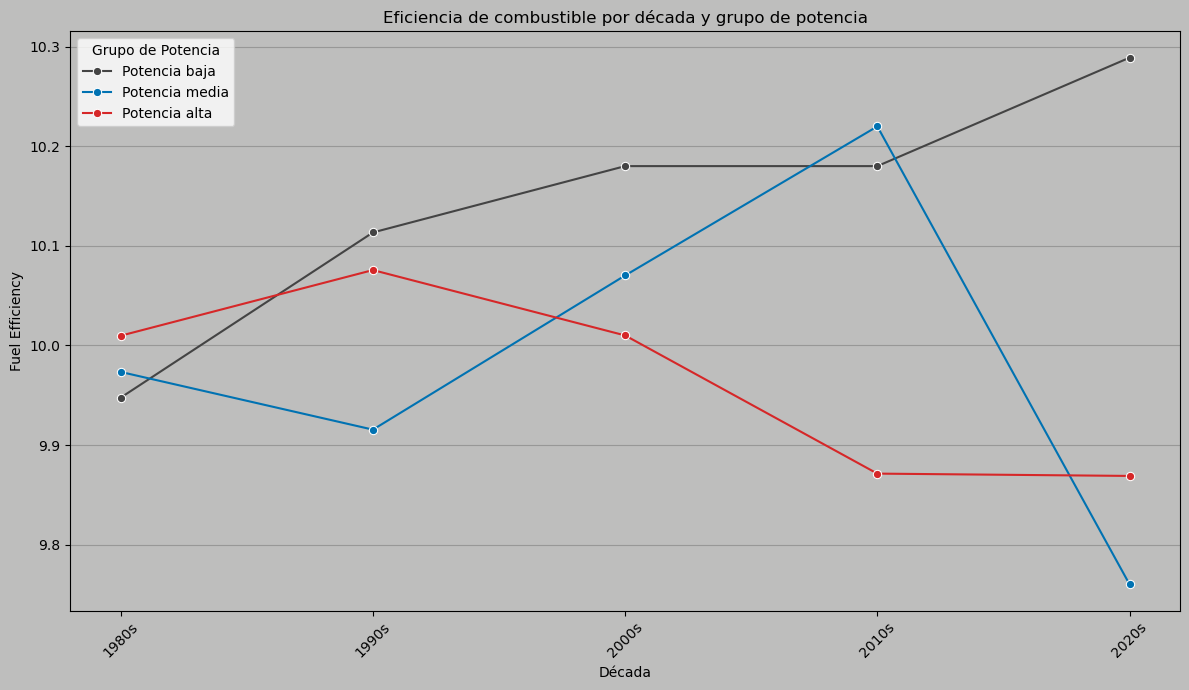

In [335]:
fig, ax = plt.subplots(figsize=(12,7), facecolor='#BEBEBD')
ax.set_facecolor('#BEBEBD')

grupos = ['Potencia baja', 'Potencia media', 'Potencia alta']
colores_grupo = {
    'Potencia baja': '#444444',  
    'Potencia media': '#0072B2', 
    'Potencia alta': '#D62728'  
}
for grupo in grupos:
    datos_grupo = df[df['Grupo_Potencia'] == grupo]
    promedio = datos_grupo.groupby('decada')['Fuel_Efficiency'].mean().sort_index()
    sns.lineplot(x=promedio.index, y=promedio.values, label=grupo, color=colores_grupo[grupo], marker='o', ax=ax)
plt.xlabel('Década')
plt.ylabel('Fuel Efficiency')
plt.title('Eficiencia de combustible por década y grupo de potencia')
plt.legend(title='Grupo de Potencia')
plt.xticks(rotation=45)
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de eficiencia de combustible
Como conclusión del gráfico se puede ver cómo la eficiencia de combustible fue positiva para motores con una Potencia baja, mientras que la eficiencia para Potencia media y Alta fue decayendo a medida que pasa el tiempo.

## GRAFICO IV
Este grafico esta diseñado con la finalidad de saber la contaminacion de CO2, si fue decendiendo o aumentando a travez del tiempo.

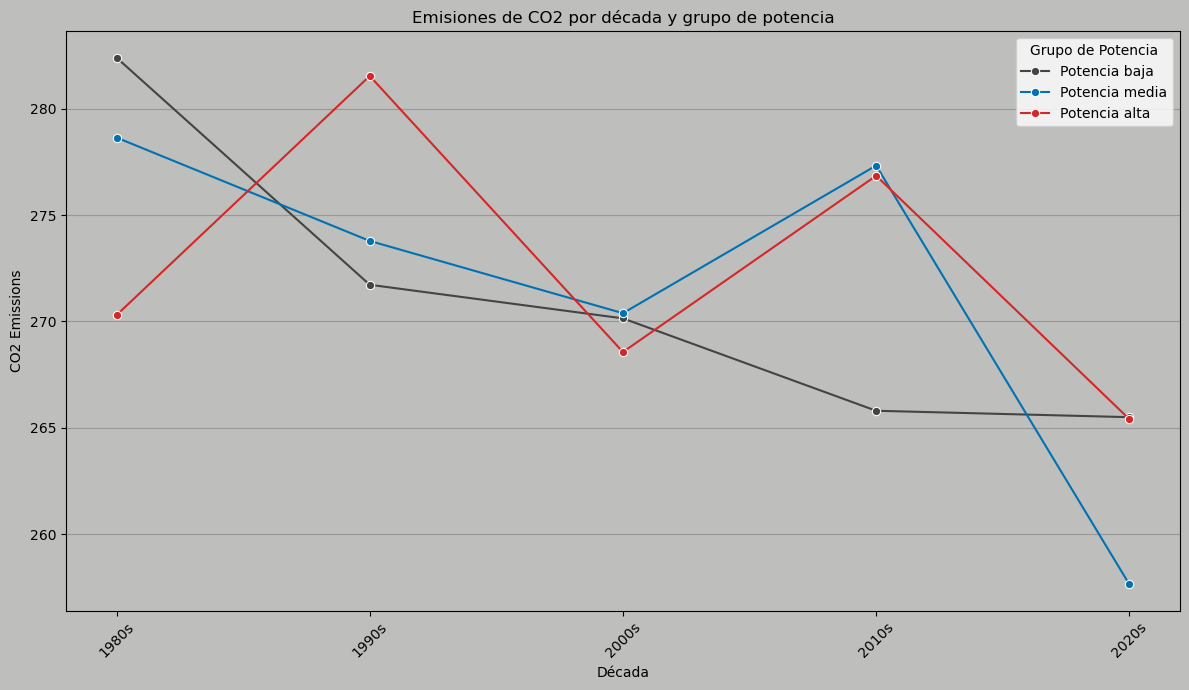

In [336]:
fig, ax = plt.subplots(figsize=(12,7), facecolor='#BEBEBD')
ax.set_facecolor('#BEBEBD')
grupos = ['Potencia baja', 'Potencia media', 'Potencia alta']
colores_grupo = {
    'Potencia baja': '#444444',  
    'Potencia media': '#0072B2', 
    'Potencia alta': '#D62728'   
}
for grupo in grupos:
    datos_grupo = df[df['Grupo_Potencia'] == grupo]
    promedio = datos_grupo.groupby('decada')['CO2_Emissions'].mean().sort_index()
    sns.lineplot(x=promedio.index, y=promedio.values, label=grupo, color=colores_grupo[grupo], marker='o')
plt.xlabel('Década')
plt.ylabel('CO2 Emissions')
plt.title('Emisiones de CO2 por década y grupo de potencia')
plt.legend(title='Grupo de Potencia')
plt.xticks(rotation=45)
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de emisiones de CO2
Como se puede ver en este gráfico, los autos con motores de potencia media son los menos contaminantes actualmente, Estos tuvieron una evolución positiva a lo largo del tiempo logrando contaminar menos al ambiente. Por el contrario, los motores con una Potencia baja y alta, aunque tuvieron una bajada, son más contaminantes que el anterior, aunque siguen siendo valores relativamente bajos.

## GRAFICO V
Este gráfico está diseñado con la finalidad de saber qué marca de automóviles tiene el mayor valor total acumulado en el mercado.

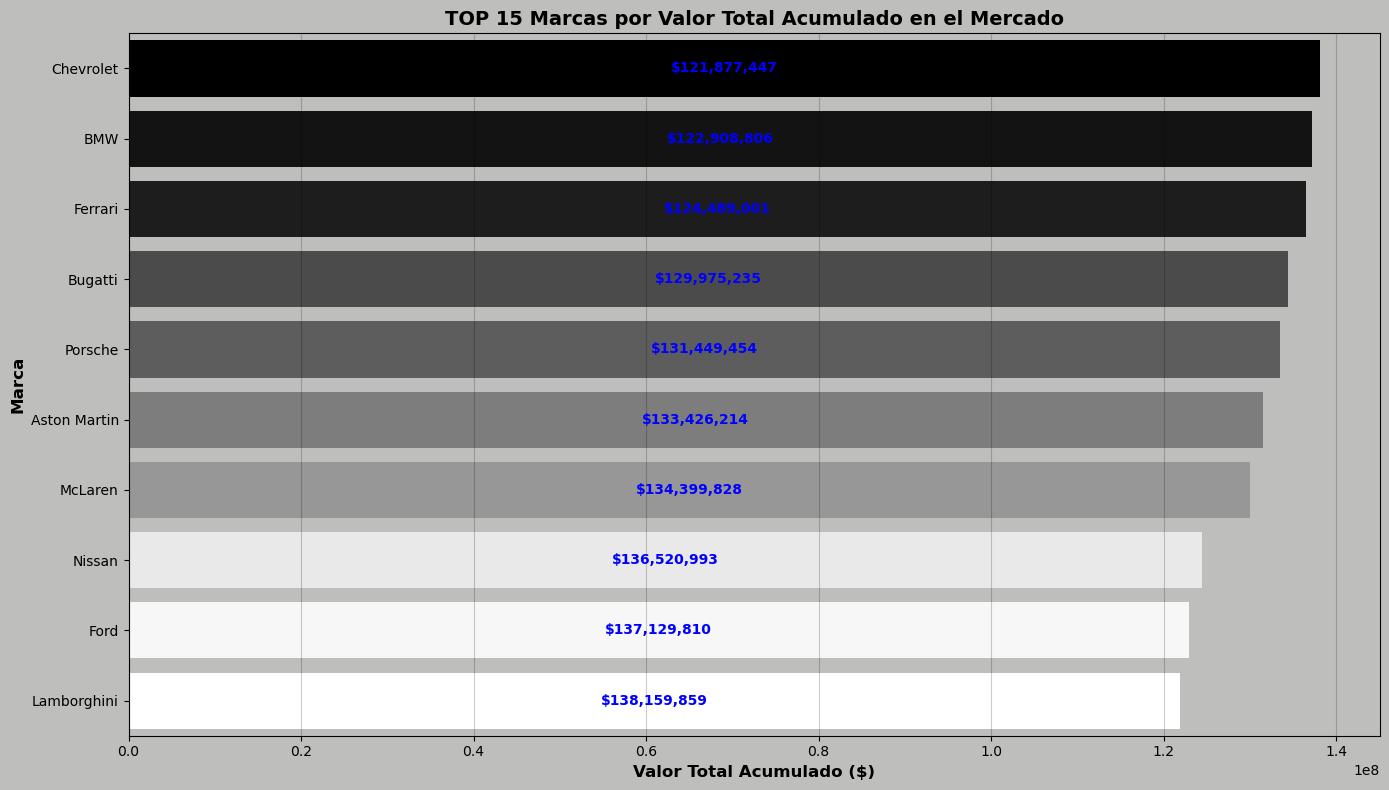

In [337]:
valor_por_marca = df.groupby('Brand')['Price'].sum().sort_values(ascending=False).head(15)

fig, ax=plt.subplots(figsize=(14,8), facecolor='#BEBEBD')
ax.set_facecolor('#BEBEBD')
bars = sns.barplot(x=valor_por_marca.values, y=valor_por_marca.index, hue=valor_por_marca.values, palette="Greys", legend=False, ax=ax)
plt.xlabel('Valor Total Acumulado ($)', fontsize=12, fontweight='bold')
plt.ylabel('Marca', fontsize=12, fontweight='bold')
plt.title('TOP 15 Marcas por Valor Total Acumulado en el Mercado', fontsize=14, fontweight='bold')
plt.grid(axis='x', color='black', alpha=0.2)
plt.tight_layout()

for i, (bar, valor) in enumerate(zip(bars.patches, valor_por_marca.values)):
    plt.text(
        bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        f'${valor:,.0f}',
        ha='center',
        va='center',
        color='blue',
        fontweight='bold',
        fontsize=10
    )

plt.show()

En este grafico podemos ver los siguientes valores

**Marca con mayor valor total:** Chevrolet ($138,159,859)

**Marca con menor valor (TOP 15):** Lamborghini ($121,877,447)

**Valor promedio por marca (TOP 15):** $131,033,665

**Diferencia entre 1° y 15°:** $16,282,412

### Conclusión del gráfico de valor por marca
Este gráfico muestra el valor total acumulado de todas las unidades de cada marca presentes en el dataset. Las marcas que lideran en valor total no necesariamente son las más caras individualmente, sino aquellas que tienen una mayor presencia en el mercado combinada con precios competitivos. Este análisis permite identificar qué fabricantes dominan el mercado en términos de valor económico total.

## Eleccion de algoritmo
Una ves terminada la exploracion y interiorizarnos mas en nuestro df, pasamos a la parte donde vamos a empezar con el algoritmo, en este caso voy a usar un algoritmo de XGBoost, algoritmo de gradient boosting que combina muchos árboles de decisión pequeños para lograr predicciones muy precisas, optimizando velocidad y rendimiento

---

## Modelo XGBoost: Identificación de Variables Influyentes

Tras evaluar múltiples algoritmos de aprendizaje supervisado, incluyendo Random Forest, modelos lineales como Linear Regression y otras variantes de regresores basados en árboles, realicé un proceso iterativo de prueba y error para comparar desempeño, estabilidad y capacidad de generalización.
Luego de este análisis exhaustivo, seleccioné XGBoost como algoritmo final debido a su superior rendimiento, su manejo eficiente de interacciones no lineales y su robustez frente a overfitting



**Variables Predictoras:**
- **Variables numéricas continuas**: Engine_Size, Horsepower, Torque, Weight, Top_Speed, Acceleration_0_100, Fuel_Efficiency, CO2_Emissions, Mileage, Safety_Rating, Number_of_Owners

**Variable Objetivo:** Price

**Metodología:**
El modelo utilizará exclusivamente variables numéricas continuas para identificar qué características técnicas y de condición tienen mayor peso en la predicción del precio. Este enfoque permite cuantificar la importancia relativa de cada atributo mediante el análisis de ganancia de información en los splits del modelo.


## PASO 1: PREPARACIÓN DE DATOS PARA XGBOOST 

In [338]:

variables_numericas_originales = [
    'Engine_Size',
    'Horsepower', 
    'Torque',
    'Weight',
    'Top_Speed',
    'Acceleration_0_100',
    'Fuel_Efficiency',
    'CO2_Emissions',
    'Mileage',
    'Safety_Rating',
    'Number_of_Owners'
]

variables_predictoras_xgb = variables_numericas_originales.copy()

X_xgb = df[variables_predictoras_xgb].copy()
y_xgb = df['Price'].copy()

nulos_X = X_xgb.isnull().sum().sum()
nulos_y = y_xgb.isnull().sum()
infinitos_X = X_xgb.select_dtypes(include=[np.number]).apply(lambda x: np.isinf(x).sum()).sum()

if nulos_X > 0 or nulos_y > 0 or infinitos_X > 0:
    X_xgb = X_xgb.replace([np.inf, -np.inf], np.nan)
    indices_validos = X_xgb.notnull().all(axis=1) & y_xgb.notnull()
    X_xgb = X_xgb[indices_validos]
    y_xgb = y_xgb[indices_validos]


## PASO 2: División Train/Test y Entrenamiento

Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%) y finalmente entrenamos el modelo XGBoost con parámetros optimizados.

In [339]:
# División train/test (80% - 20%)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

print('División completada:')
print(f'   Conjunto de entrenamiento: {X_train_xgb.shape[0]:,} muestras')
print(f'   Conjunto de prueba: {X_test_xgb.shape[0]:,} muestras')

modelo_xgb = xgb.XGBRegressor(
    n_estimators=300,          
    max_depth=3,              
    learning_rate=0.05,        
    subsample=0.8,            
    colsample_bytree=0.8,     
    min_child_weight=30,      
    reg_alpha=5.0,            
    reg_lambda=15,              
    gamma=1.0,                 
    random_state=42,           
    n_jobs=-1,              
    verbosity=0              
)

modelo_xgb.fit(X_train_xgb, y_train_xgb)

print(' Modelo XGBoost entrenado!')


División completada:
   Conjunto de entrenamiento: 4,000 muestras
   Conjunto de prueba: 1,000 muestras
 Modelo XGBoost entrenado!


## PASO 3: Evaluación del Modelo XGBoost

Calculamos las métricas de rendimiento del modelo: R², MAE (Error Absoluto Medio) y RMSE (Raíz del Error Cuadrático Medio) para evaluar la precisión del modelo tanto en datos de entrenamiento como de prueba.

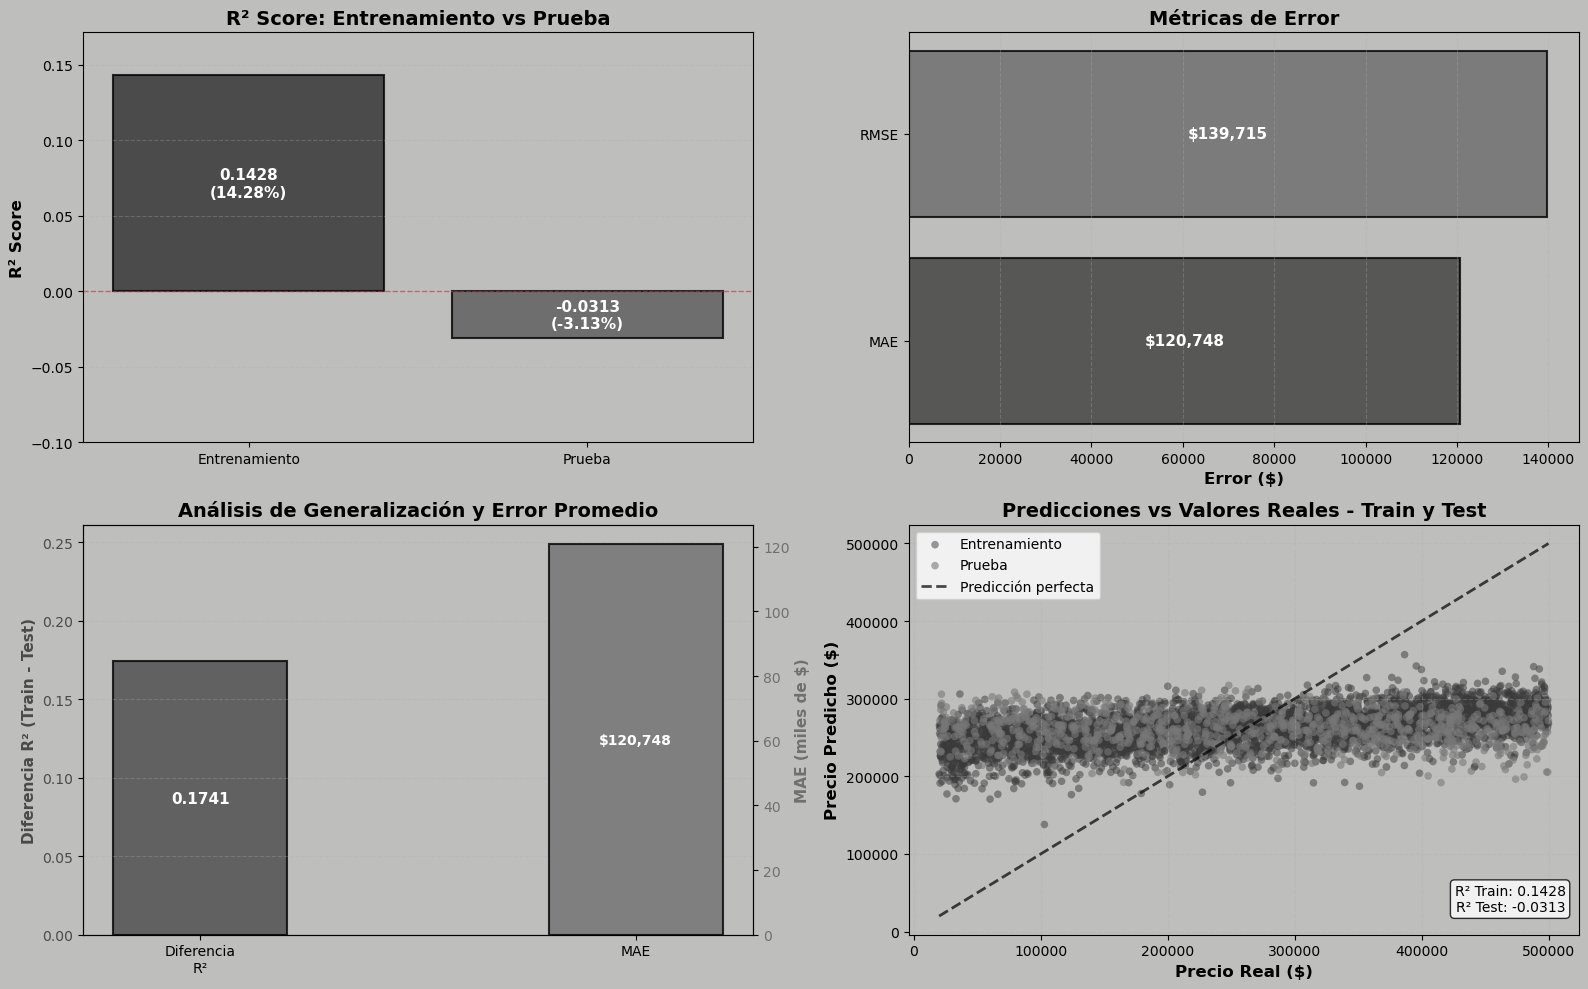

In [340]:
y_train_pred_xgb = modelo_xgb.predict(X_train_xgb)
y_test_pred_xgb = modelo_xgb.predict(X_test_xgb)

r2_train_xgb = r2_score(y_train_xgb, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test_xgb, y_test_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test_xgb, y_test_pred_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_test_pred_xgb))

diferencia_r2_xgb = r2_train_xgb - r2_test_xgb

# Generamos visualizaciones para mostrar el desempeño del modelo
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.patch.set_facecolor('#BEBEBD')

r2_data = pd.DataFrame({
    'Conjunto': ['Entrenamiento', 'Prueba'],
    'R² Score': [r2_train_xgb, r2_test_xgb]
})

axes[0, 0].set_facecolor('#BEBEBD')
bars = axes[0, 0].bar(r2_data['Conjunto'], r2_data['R² Score'], 
                       color=['#2F2F2F', '#5A5A5A'], edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('R² Score: Entrenamiento vs Prueba', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(-0.1, max(r2_train_xgb, r2_test_xgb) * 1.2)
axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

for bar, valor in zip(bars, r2_data['R² Score']):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{valor:.4f}\n({valor*100:.2f}%)',
                    ha='center', va='center', fontsize=11, fontweight='bold', color='white')

metricas_error = pd.DataFrame({
    'Métrica': ['MAE', 'RMSE'],
    'Valor': [mae_test_xgb, rmse_test_xgb]
})

axes[0, 1].set_facecolor('#BEBEBD')
bars2 = axes[0, 1].barh(metricas_error['Métrica'], metricas_error['Valor'],
                         color=['#3D3D3D', '#6B6B6B'], edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0, 1].set_xlabel('Error ($)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Métricas de Error', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3, linestyle='--')

for bar, valor in zip(bars2, metricas_error['Valor']):
    width = bar.get_width()
    axes[0, 1].text(width/2, bar.get_y() + bar.get_height()/2,
                    f'${valor:,.0f}',
                    ha='center', va='center', fontsize=11, fontweight='bold', color='white')

ax3 = axes[1, 0]
ax3.set_facecolor('#BEBEBD')
ax3_twin = ax3.twinx()

bar_dif = ax3.bar(['Diferencia\nR²'], [diferencia_r2_xgb], 
                   color='#4A4A4A', edgecolor='black', linewidth=1.5, alpha=0.8, width=0.4)
ax3.set_ylabel('Diferencia R² (Train - Test)', fontsize=11, fontweight='bold', color='#4A4A4A')
ax3.tick_params(axis='y', labelcolor='#4A4A4A')
ax3.set_ylim(0, diferencia_r2_xgb * 1.5)

bar_mae = ax3_twin.bar(['MAE'], [mae_test_xgb/1000], 
                        color='#707070', edgecolor='black', linewidth=1.5, alpha=0.8, width=0.4)
ax3_twin.set_ylabel('MAE (miles de $)', fontsize=11, fontweight='bold', color='#707070')
ax3_twin.tick_params(axis='y', labelcolor='#707070')

ax3.set_title('Análisis de Generalización y Error Promedio', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

ax3.text(0, diferencia_r2_xgb/2, f'{diferencia_r2_xgb:.4f}',
         ha='center', va='center', fontsize=11, fontweight='bold', color='white')
ax3_twin.text(1, (mae_test_xgb/1000)/2, f'${mae_test_xgb:,.0f}',
              ha='center', va='center', fontsize=10, fontweight='bold', color='white')

y_train_pred_original = y_train_pred_xgb
y_train_original = y_train_xgb
y_test_pred_original = y_test_pred_xgb
y_test_original = y_test_xgb

axes[1, 1].set_facecolor('#BEBEBD')
axes[1, 1].scatter(y_train_original, y_train_pred_original, 
                   alpha=0.5, s=30, color='#3A3A3A', edgecolors='none', label='Entrenamiento')

axes[1, 1].scatter(y_test_original, y_test_pred_original, 
                   alpha=0.6, s=30, color='#787878', edgecolors='none', label='Prueba')

min_val = min(y_train_original.min(), y_test_original.min())
max_val = max(y_train_original.max(), y_test_original.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 
                'k--', linewidth=2, alpha=0.7, label='Predicción perfecta')

axes[1, 1].set_xlabel('Precio Real ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Precio Predicho ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Predicciones vs Valores Reales - Train y Test', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='upper left', fontsize=10)
axes[1, 1].grid(alpha=0.3, linestyle='--')

axes[1, 1].text(0.98, 0.05, 
                f'R² Train: {r2_train_xgb:.4f}\nR² Test: {r2_test_xgb:.4f}',
                transform=axes[1, 1].transAxes,
                fontsize=10, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))

plt.tight_layout()
plt.show()

Si bien se que no son necesariamente relevantes las metricas en el trabajo numero 1, quise ponerlas para ir interiorizandome en ellas

### 📌 PASO 4: Importancia de Variables en XGBoost

Analizamos qué variables tienen mayor peso en el modelo XGBoost para evaluar el auto.

In [341]:
# Obtener importancias del modelo XGBoost
importancias_xgb = modelo_xgb.feature_importances_
nombres_variables_xgb = X_train_xgb.columns

# Crear DataFrame con importancias
df_importancias_xgb = pd.DataFrame({
    'Variable': nombres_variables_xgb,
    'Importancia': importancias_xgb
}).sort_values('Importancia', ascending=False)

# Calcular porcentaje
df_importancias_xgb['Porcentaje'] = (df_importancias_xgb['Importancia'] / df_importancias_xgb['Importancia'].sum()) * 100



### 📌 PASO 5: Visualización de la Importancia de Variables

Generamos gráficos para visualizar de forma clara qué variables tienen mayor peso en el modelo XGBoost.

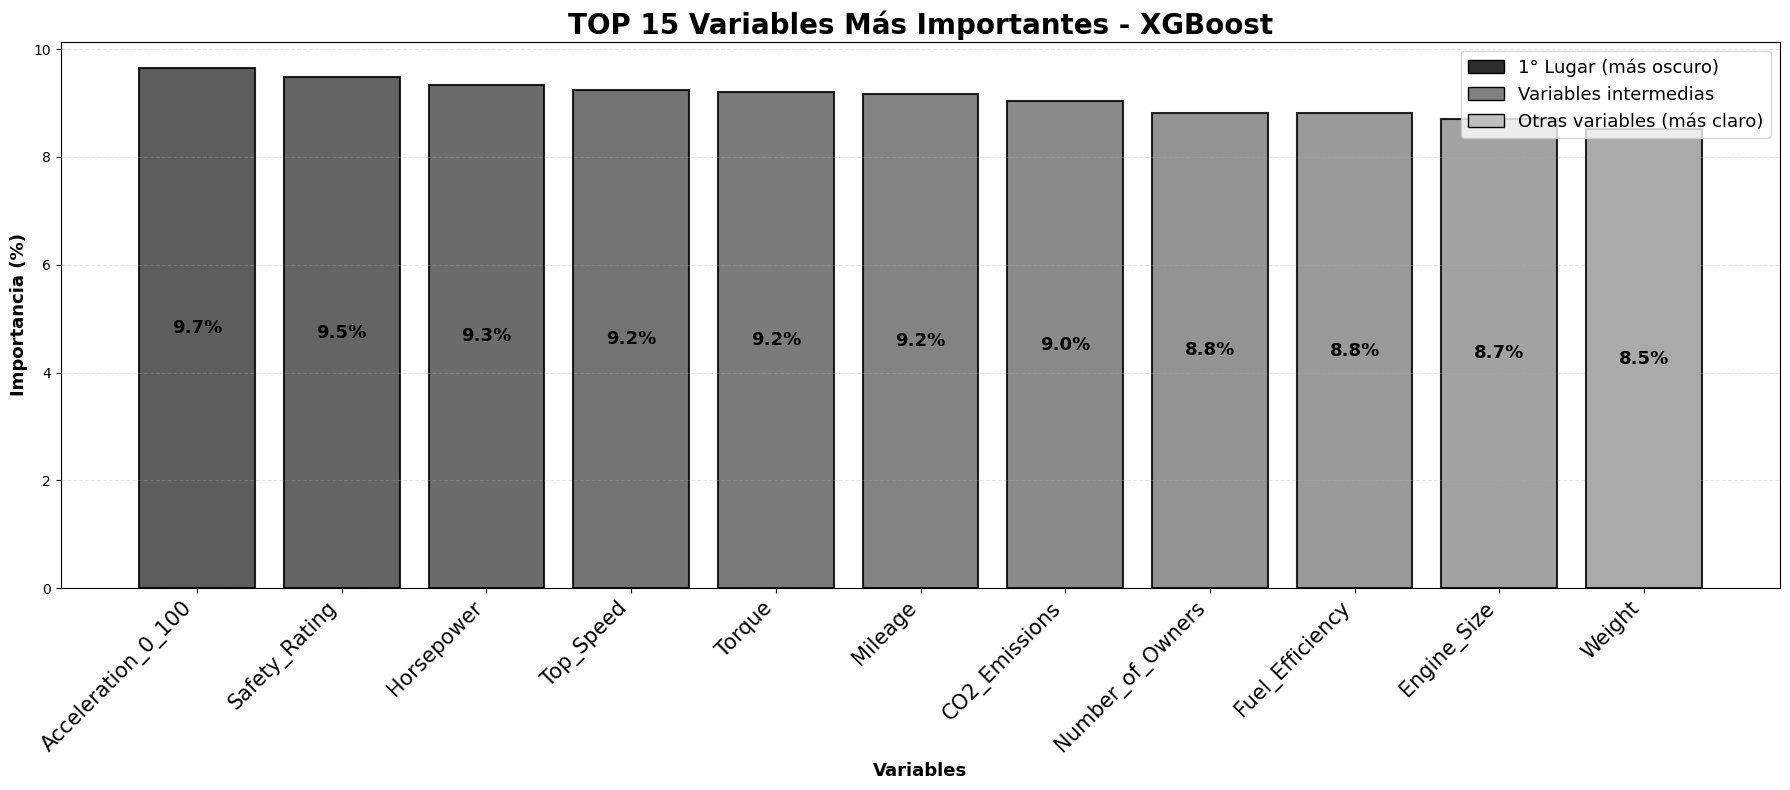

In [343]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

# Gráfico: TOP 15 variables con barras verticales
top_15 = df_importancias_xgb.head(15)

# Paleta de grises degradados para TOP 15
colores_top15 = [mcolors.to_hex((i/14 * 0.5 + 0.25, i/14 * 0.5 + 0.25, i/14 * 0.5 + 0.25)) 
                 for i in range(15)]

bars = ax.bar(range(len(top_15)), top_15['Porcentaje'], 
       color=colores_top15, edgecolor='black', alpha=0.85, linewidth=1.5)

ax.set_xlabel('Variables', fontsize=13, fontweight='bold')
ax.set_ylabel('Importancia (%)', fontsize=13, fontweight='bold')
ax.set_title('TOP 15 Variables Más Importantes - XGBoost', fontsize=20, fontweight='bold')
ax.set_xticks(range(len(top_15)))
ax.set_xticklabels(top_15['Variable'], rotation=45, ha='right', fontsize=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Agregar valores DENTRO de las barras (centrados verticalmente)
for i, (bar, valor) in enumerate(zip(bars, top_15['Porcentaje'])):
    # Calcular la posición vertical en el centro de la barra
    altura_barra = bar.get_height()
    posicion_y = altura_barra / 2
    
    ax.text(bar.get_x() + bar.get_width() / 2, posicion_y, 
            f"{valor:.1f}%", 
            ha='center', va='center', fontsize=13, fontweight='bold', color='black')

# Leyenda sin emojis para evitar warnings
legend_elements = [
    Patch(facecolor="#2E2D2D", label='1° Lugar (más oscuro)', edgecolor='black'),
    Patch(facecolor='#808080', label='Variables intermedias', edgecolor='black'),
    Patch(facecolor='#BFBFBF', label='Otras variables (más claro)', edgecolor='black')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=13)

plt.tight_layout()
plt.show()




## Conclusiones del Modelo

### Rendimiento General del Modelo

El modelo XGBoost desarrollado para predecir el precio de vehículos usados ha mostrado un rendimiento modesto tras la optimización de hiperparámetros. El modelo explica el 14.28% de la variabilidad en los precios del conjunto de entrenamiento (R² = 0.1428), mientras que en el conjunto de prueba presenta un R² de -3.13%, lo que indica dificultades significativas para generalizar a datos no vistos.

La diferencia entre el rendimiento de entrenamiento y prueba se ha reducido a 0.1739, una mejora sustancial respecto a configuraciones anteriores, lo que sugiere que el modelo está menos sobreajustado. Sin embargo, el rendimiento negativo en prueba señala que el modelo aún requiere mejoras adicionales.

### Variables con Mayor Influencia en el Precio

El análisis de importancia de variables revela qué características tienen mayor peso en la determinación del precio de un vehículo:

**1. Aceleración 0-100 km/h (Acceleration_0_100) - 9.65%**  
Esta variable emerge como el factor más determinante en la predicción del precio. Los vehículos con mejor capacidad de aceleración tienden a tener valores significativamente más elevados, reflejando la demanda del mercado por automóviles de alto rendimiento dinámico.

**2. Calificación de Seguridad (Safety_Rating) - 9.48%**  
La puntuación de seguridad representa el segundo factor más influyente. Mayores estándares de seguridad se asocian con vehículos de gama superior y mejor calidad general, justificando precios más altos en el mercado.

**3. Caballos de Fuerza (Horsepower) - 9.34%**  
La potencia del motor constituye el tercer predictor más relevante. Mayor cantidad de caballos de fuerza se relaciona con mejor performance y prestaciones superiores, características altamente valoradas por los compradores.

**4. Velocidad Máxima (Top_Speed) - 9.24%**  
La capacidad de alcanzar velocidades superiores muestra una relación significativa con el precio, siendo un indicador clave de las capacidades técnicas del vehículo.

**5. Torque - 9.21%**  
La fuerza de rotación del motor se posiciona como el quinto factor más importante. Un mayor torque se asocia con mejor capacidad de aceleración y arrastre, elementos fundamentales en la valoración del mercado automotriz.

### Otras Variables Relevantes

- **Kilometraje (Mileage) - 9.17%**: Como era de esperarse, menor kilometraje se asocia fuertemente con precios más altos.
- **Emisiones de CO2 (CO2_Emissions) - 9.03%**: Factor importante relacionado con restricciones ambientales y costos operativos.
- **Número de Propietarios (Number_of_Owners) - 8.82%**: Menor cantidad de dueños previos incrementa el valor percibido del vehículo.
- **Eficiencia de Combustible (Fuel_Efficiency) - 8.81%**: Impacta en el costo de operación a largo plazo y atractivo del vehículo.
- **Tamaño del Motor (Engine_Size) - 8.71%**: El desplazamiento del motor influye en la percepción de potencia y categoría del vehículo.
- **Peso del Vehículo (Weight) - 8.52%**: El peso puede indicar mayor tamaño, materiales de calidad o capacidades especiales que afectan el precio.

### Implicaciones Prácticas

Los resultados del modelo XGBoost revelan una distribución excepcionalmente equilibrada en la importancia de las variables. Las 11 características numéricas analizadas presentan valores de importancia notablemente similares, oscilando entre 8.52% y 9.65%, con una diferencia de apenas 1.13 puntos porcentuales entre la variable más y menos influyente.

Esta distribución uniforme (las TOP 10 variables explican el 91.48% de la importancia total) sugiere que el precio de un vehículo es el resultado de un equilibrio multifactorial donde ninguna característica domina absolutamente sobre las demás.

Para vendedores y compradores, esto significa que al valorar un vehículo deben considerar el conjunto completo de atributos técnicos, ya que todos contribuyen de manera significativa y equilibrada al valor final. No existe una "variable mágica" que determine el precio por sí sola; más bien, el mercado automotriz valora de forma integral las prestaciones, la condición física y las características operativas del vehículo.
